# **Springboard Decision Tree Specialty Coffee Case Study - Tier 3**




# The Scenario

Imagine you've just finished the Springboard Data Science Career Track course, and have been hired by a rising popular specialty coffee company - RR Diner Coffee - as a data scientist. Congratulations!

RR Diner Coffee sells two types of thing:
- specialty coffee beans, in bulk (by the kilogram only) 
- coffee equipment and merchandise (grinders, brewing equipment, mugs, books, t-shirts).

RR Diner Coffee has three stores, two in Europe and one in the USA. The flagshap store is in the USA, and everything is quality assessed there, before being shipped out. Customers further away from the USA flagship store have higher shipping charges. 

You've been taken on at RR Diner Coffee because the company are turning towards using data science and machine learning to systematically make decisions about which coffee farmers they should strike deals with. 

RR Diner Coffee typically buys coffee from farmers, processes it on site, brings it back to the USA, roasts it, packages it, markets it, and ships it (only in bulk, and after quality assurance) to customers internationally. These customers all own coffee shops in major cities like New York, Paris, London, Hong Kong, Tokyo, and Berlin. 

Now, RR Diner Coffee has a decision about whether to strike a deal with a legendary coffee farm (known as the **Hidden Farm**) in rural China: there are rumours their coffee tastes of lychee and dark chocolate, while also being as sweet as apple juice. 

It's a risky decision, as the deal will be expensive, and the coffee might not be bought by customers. The stakes are high: times are tough, stocks are low, farmers are reverting to old deals with the larger enterprises and the publicity of selling *Hidden Farm* coffee could save the RR Diner Coffee business. 

Your first job, then, is ***to build a decision tree to predict how many units of the Hidden Farm Chinese coffee will be purchased by RR Diner Coffee's most loyal customers.*** 

To this end, you and your team have conducted a survey of 710 of the most loyal RR Diner Coffee customers, collecting data on the customers':
- age
- gender 
- salary 
- whether they have bought at least one RR Diner Coffee product online
- their distance from the flagship store in the USA (standardized to a number between 0 and 11) 
- how much they spent on RR Diner Coffee products on the week of the survey 
- how much they spent on RR Diner Coffee products in the month preeding the survey
- the number of RR Diner coffee bean shipments each customer has ordered over the preceding year. 

You also asked each customer participating in the survey whether they would buy the Hidden Farm coffee, and some (but not all) of the customers gave responses to that question. 

You sit back and think: if more than 70% of the interviewed customers are likely to buy the Hidden Farm coffee, you will strike the deal with the local Hidden Farm farmers and sell the coffee. Otherwise, you won't strike the deal and the Hidden Farm coffee will remain in legends only. There's some doubt in your mind about whether 70% is a reasonable threshold, but it'll do for the moment. 

To solve the problem, then, you will build a decision tree to implement a classification solution. 


-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest. This is ***tier 3***, so it will be challenging. 

**1. Sourcing and loading** 
- Import packages
- Load data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Cleaning the data
- Train/test split
  
  
**3. Modelling** 
- Model 1: Entropy model - no max_depth
- Model 2: Gini impurity model - no max_depth
- Model 3: Entropy model - max depth 3
- Model 4: Gini impurity model - max depth 3


**4. Evaluating and concluding** 
- How many customers will buy Hidden Farm coffee?
- Decision

**5. Random Forest** 
- Import necessary modules
- Model
- Revise conclusion
    

# 0. Overview

This notebook uses decision trees to determine whether the factors of salary, gender, age, how much money the customer spent last week and during the preceding month on RR Diner Coffee products, how many kilogram coffee bags the customer bought over the last year, whether they have bought at least one RR Diner Coffee product online, and their distance from the flagship store in the USA, could predict whether customers would purchase the Hidden Farm coffee if a deal with its farmers were struck. 

# 1. Sourcing and loading
## 1a. Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

Define constants

In [2]:
COL = sns.color_palette('#7A6C5F #76AD9A #59627A #667A73'.split())
T_T_SPLIT_SEED = 246
TREE_SEED = 1234

Apply settings

In [3]:
sns.set_palette(COL)

Define functions

In [4]:
def labeled_print(label: str, item: object, join_by: str='') -> None:
    '''Print a label and an item with a divider. If a string is
    passed to join_by, join an iterable item before printing.
    '''
    if join_by:
        item = join_by.join(f'{_}' for _ in item)
    print(f'{label}:\n' + 79*'=' + f'\n{item}')
def print_incorrect(
        y_p:pd.Series, y_t:pd.Series) -> None:
    '''Print the index, predicted classification, and test set classification
    for incorrectly classified entries returned by a given model.
    '''
    incorrect = [
        '  |  '.join([
            f'[index: ' + f'{i}]'.rjust(len(f'{len(y_t)}') + 1), 
            'predicted:' + f'{y_p.iloc[i]}'.rjust(5),
            'actual: '+ f'{y_t.iloc[i]}'.rjust(5)
        ]) for i in range(len(y_p)) 
        if y_p.iloc[i]!=y_t.iloc[i]
    ]
    labeled_print('incorrect classifications', incorrect, '\n')
def fit_train_predict(
            model: BaseEstimator, X_train: pd.DataFrame, 
            y_train: pd.Series, X_test: pd.DataFrame) -> pd.Series:
    '''Fit a model to X and y training subsets. Render predictions for an X
    test subset. Return a pandas Series containing predictions.
    '''
    model.fit(X_train, y_train)
    return pd.Series(model.predict(X_test))
def tree_plot(model: BaseEstimator, feature_names: list[str]) -> None:
    '''Plot a decision tree.
    '''
    labeled_print(f'model: {model}', 
                  'Branch Paths:\n<<< True <<<   >>> False >>>')
    plt.figure(figsize=(15, 15))
    tree.plot_tree(
        model, filled=True, feature_names=feature_names, rounded=True,
        fontsize=10
    )
    plt.show();
    labeled_print('model classes', list(model.classes_), ', ')


## 1b. Load data 

In [5]:
# Read in the data to a variable called coffeeData
coffee = pd.read_csv('data/RRDinerCoffeeData.csv')

## 1c. Explore the data

As we've seen, exploration entails doing things like checking out the **initial appearance** of the data with head(), the **dimensions** of our data with .shape, the **data types** of the variables with .info(), the **number of non-null values**, how much **memory** is being used to store the data, and finally the major summary statistcs capturing **central tendancy, dispersion and the null-excluding shape of the dataset's distribution**. 

How much of this can you do yourself by this point in the course? Have a real go. 

In [6]:
coffee.head(3)

Age  Gender  num_coffeeBags_per_year  spent_week  spent_month  SlrAY  \
0   36  Female                        0          24           73  42789   
1   24    Male                        0          44          164  74035   
2   24    Male                        0          39          119  30563   

   Distance  Online  Decision  
0  0.003168       0       1.0  
1  0.520906       0       NaN  
2  0.916005       1       1.0

In [7]:
# Call .shape on your data
coffee.shape

(702, 9)

In [8]:
# Call info() on your data
coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      702 non-null    int64  
 1   Gender                   702 non-null    object 
 2   num_coffeeBags_per_year  702 non-null    int64  
 3   spent_week               702 non-null    int64  
 4   spent_month              702 non-null    int64  
 5   SlrAY                    702 non-null    int64  
 6   Distance                 702 non-null    float64
 7   Online                   702 non-null    int64  
 8   Decision                 474 non-null    float64
dtypes: float64(2), int64(6), object(1)
memory usage: 49.5+ KB


In [9]:
# Call describe() on your data to get the relevant summary statistics for your data 
coffee.describe()

Age  num_coffeeBags_per_year  spent_week  spent_month  \
count  702.000000               702.000000  702.000000   702.000000   
mean    34.243590                 2.710826   32.853276   107.923077   
std     13.927945                 1.593629   15.731878    55.348485   
min     16.000000                 0.000000    0.000000     0.000000   
25%     23.000000                 1.000000   24.250000    62.000000   
50%     28.000000                 3.000000   36.000000   113.500000   
75%     46.000000                 4.000000   43.000000   150.750000   
max     90.000000                 5.000000   62.000000   210.000000   

               SlrAY    Distance      Online    Decision  
count     702.000000  702.000000  702.000000  474.000000  
mean    43819.843305    4.559186    0.531339    0.639241  
std     26192.626943    3.116275    0.499373    0.480728  
min      1617.000000    0.003168    0.000000    0.000000  
25%     22812.250000    1.877812    0.000000    0.000000  
50%     41975.000000    4.196167    1.000000    1.000000  
75%     60223.000000    6.712022    1.000000    1.000000  
max    182058.000000   10.986203    1.000000    1.000000

# 2. Cleaning, transforming and visualizing
## 2a. Cleaning the data

Some datasets don't require any cleaning, but almost all do. This one does. We need to replace '1.0' and '0.0' in the 'Decision' column by 'YES' and 'NO' respectively, clean up the values of the 'gender' column, and change the column names to words which maximize meaning and clarity. 

First, let's change the name of `spent_week`, `spent_month`, and `SlrAY` to `spent_last_week` and `spent_last_month` and `salary` respectively.

In [10]:
# Check out the names of our data's columns 
labeled_print('column names', list(coffee.columns), '\n')

column names:
Age
Gender
num_coffeeBags_per_year
spent_week
spent_month
SlrAY
Distance
Online
Decision


In [11]:
# Make the relevant name changes to spent_week and spent_per_week.
coffee_columns = dict(zip(
    list(coffee.columns), list(map(str.lower, list(coffee.columns)))
))
for old, new in {
        'SlrAY' : 'salary', 'spent_week': 'spent_last_week', 
        'spent_month': 'spent_last_month', 
        'num_coffeeBags_per_year' : 'bags_per_year'}.items():
    coffee_columns[old] = new
coffee.rename(columns=coffee_columns, inplace=True)

In [12]:
# Check out the column names
labeled_print('column names', list(coffee.columns), '\n')

column names:
age
gender
bags_per_year
spent_last_week
spent_last_month
salary
distance
online
decision


In [13]:
# Let's have a closer look at the gender column. Its values need cleaning.
# See the gender column's unique values 
labeled_print('Unique values in coffee.gender', coffee.gender.unique(), ', ')

Unique values in coffee.gender:
Female, Male, female, F, f , FEMALE, MALE, male, M


We can see a bunch of inconsistency here.

Use replace() to make the values of the `gender` column just `Female` and `Male`.

In [14]:
# Replace all alternate values for the Female entry with 'Female'
# Replace all alternate values with "Male"
coffee.replace(
    {'gender':{'[fF].*':'Female', '(?<!([fF].))[mM].*':'Male'}}, inplace=True,
    regex=True
)

In [15]:
# Check out the unique values for the 'gender' column
coffee.gender.unique()

array(['Female', 'Male'], dtype=object)

In [16]:
# Check out the unique values of the column 'Decision'
coffee.decision.value_counts(dropna=False)

1.0    303
NaN    228
0.0    171
Name: decision, dtype: int64

We now want to replace `1.0` and `0.0` in the `Decision` column by `YES` and `NO` respectively.

In [17]:
# Replace 1.0 and 0.0 by 'Yes' and 'No'
coffee.replace({'decision': {1:'Yes', 0:'No'}}, inplace=True)

In [18]:
# Check that our replacing those values with 'YES' and 'NO' worked, with unique()
labeled_print('Unique values in coffee.decision',
              list(coffee.decision.value_counts(dropna=False).index), ', ')

Unique values in coffee.decision:
Yes, nan, No


## 2b. Train/test split
To execute the train/test split properly, we need to do five things: 
1. Drop all rows with a null value in the `Decision` column, and save the result as NOPrediction: a dataset that will contain all known values for the decision 
2. Visualize the data using scatter and boxplots of several variables in the y-axis and the decision on the x-axis
3. Get the subset of coffeeData with null values in the `Decision` column, and save that subset as Prediction
4. Divide the NOPrediction subset into X and y, and then further divide those subsets into train and test subsets for X and y respectively
5. Create dummy variables to deal with categorical inputs

### 1. Drop all null values within the `Decision` column, and save the result as NoPrediction

In [19]:
# NoPrediction will contain all known values for the decision
# Call dropna() on coffeeData, and store the result in a variable NOPrediction 
# Call describe() on the Decision column of NoPrediction after calling dropna() on coffeeData
no_prediction = coffee.copy().dropna()
no_prediction.decision.describe()

count     474
unique      2
top       Yes
freq      303
Name: decision, dtype: object

### 2. Visualize the data using scatter and boxplots of several variables in the y-axis and the decision on the x-axis

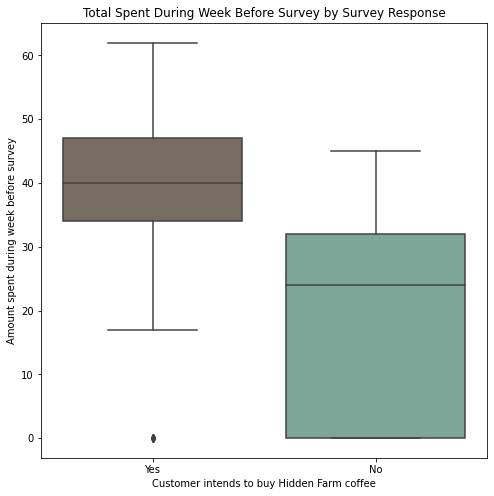

In [20]:
# Exploring our new NOPrediction dataset
# Make a boxplot on NOPrediction where the x axis is Decision, and the y axis is spent_last_week
fig = plt.figure(figsize=(8,8))
sns.boxplot(x=no_prediction['decision'], y=no_prediction['spent_last_week'])
plt.title('Total Spent During Week Before Survey by Survey Response')
plt.xlabel('Customer intends to buy Hidden Farm coffee')
plt.ylabel('Amount spent during week before survey')
plt.show();

<b>Can you admissibly conclude anything from this boxplot? Write your answer here:</b><br><br>
I don't understand the phrase "admissibly conclude". Admissible to what?<br><br>
The above plot compares distributions of customer spending during the week before the survey for those survey respondents that gave a yes or no answer to a question asking whether they would purchase Hidden Farm cofffee. During that single week, respondents that answered yes tended to spend more money than respondents that answered no, given the relative positions of respective medians and IQRs. There may be a relationship between survey response and spending habits, but this only measures spending during one week, and the only measured customers are those that both responded to this survey and gave a yes or no answer to its primary question.

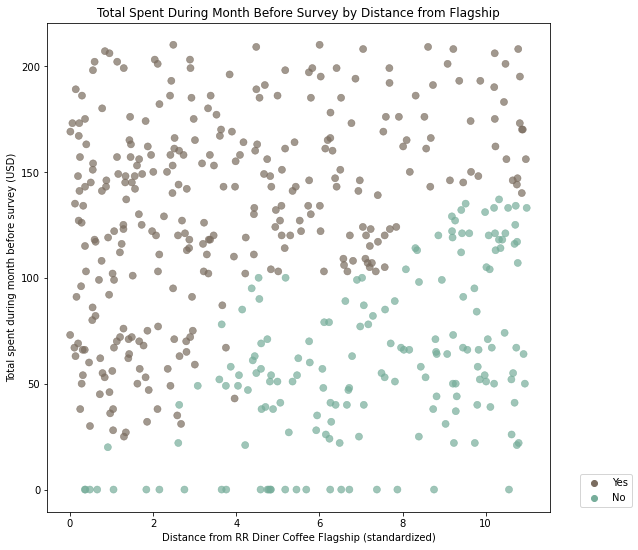

In [21]:
# Make a scatterplot on NOPrediction, where x is distance, y is spent_last_month and hue is Decision 
plt.figure(figsize=(9,9))
sns.scatterplot(
    data=no_prediction,x='distance',y='spent_last_month',hue='decision', s=50, alpha=0.7,edgecolor=None
)
plt.xlabel('Distance from RR Diner Coffee Flagship (standardized)')
plt.ylabel('Total spent during month before survey (USD)')
plt.title('Total Spent During Month Before Survey by Distance from Flagship')
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0))
plt.show();

Can you admissibly conclude anything from this scatterplot? Remember: we are trying to build a tree to classify unseen examples. Write your answer here:<br><br>
The intrinsic dimensionality of respondent decision, distance from RR Diner Coffee's flagship location, and total spent during the month before the survey is 1. These features are easily approximated by a line. The probability of a 'Yes" response given a distance from RR Diner Coffee's flagship location approaches 1 as total spent during the month before the survey increases above this line. This same probability approaches 0 as total spent during this month decreases below this line. A composite feature could replace `spent_last_month` and `distance` when building a model to predict survey response.

### 3. Get the subset of coffeeData with null values in the Decision column, and save that subset as Prediction

In [22]:
# Get just those rows whose value for the Decision column is null  
prediction = coffee.copy().loc[coffee.decision.isnull()]

In [23]:
# Call describe() on Prediction
prediction.describe()

age  bags_per_year  spent_last_week  spent_last_month  \
count  228.000000     228.000000       228.000000        228.000000   
mean    31.802632       2.960526        33.394737        110.407895   
std     14.302293       1.585514        15.697930         53.786536   
min     16.000000       0.000000         0.000000          0.000000   
25%     22.000000       2.000000        25.750000         65.000000   
50%     25.000000       3.000000        37.000000        113.500000   
75%     39.000000       4.000000        44.000000        151.250000   
max     67.000000       5.000000        62.000000        210.000000   

              salary    distance      online  
count     228.000000  228.000000  228.000000  
mean    41923.741228    3.428836    0.570175  
std     27406.768360    2.153102    0.496140  
min      1617.000000    0.010048    0.000000  
25%     15911.500000    1.699408    0.000000  
50%     40987.500000    3.208673    1.000000  
75%     58537.000000    5.261184    1.000000  
max    182058.000000   10.871566    1.000000

### 4. Divide the NOPrediction subset into X and y

In [24]:
# Check the names of the columns of NOPrediction
labeled_print('no_prediction column names', no_prediction.columns, ', ')

no_prediction column names:
age, gender, bags_per_year, spent_last_week, spent_last_month, salary, distance, online, decision


In [25]:
# Let's do our feature selection.
# Make a variable called 'features', and a list containing the strings of every column except "Decision"
features = list(no_prediction.columns)
features.remove('decision')
# Make an explanatory variable called X, and assign it: NoPrediction[features]
X = no_prediction.copy().loc[:, features]
# Make a dependent variable called y, and assign it: NoPrediction.Decision
y = no_prediction.copy().decision

### 5. Create dummy variables to deal with categorical inputs
One-hot encoding replaces each unique value of a given column with a new column, and puts a 1 in the new column for a given row just if its initial value for the original column matches the new column. Check out [this resource](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) if you haven't seen one-hot-encoding before. 

**Note**: We will do this before we do our train/test split as to do it after could mean that some categories only end up in the train or test split of our data by chance and this would then lead to different shapes of data for our `X_train` and `X_test` which could/would cause downstream issues when fitting or predicting using a trained model.

In [26]:
# One-hot encode all features in X.
X = pd.get_dummies(X)
feature_names = list(X.columns)

### 6. Further divide those subsets into train and test subsets for X and y respectively: X_train, X_test, y_train, y_test

In [27]:
# Call train_test_split on X, y. Make the test_size = 0.25, and random_state = 246
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=T_T_SPLIT_SEED)

Check class imbalance. Check composition of subsets.

In [28]:
print('Decision values by subset')
for subset, name in (
        (no_prediction.decision, 'All respondents with answers'), 
        (y_train, 'Training'), (y_test, 'Test')):
    print(79*'=' + f'\n{name}:')
    for _ in 'Yes No'.split():
        print(f'{_}:'.ljust(5) 
              + f'{subset.value_counts()[_]}'.rjust(5).ljust(10)
              + f'{100*subset.value_counts(normalize=True)[_]:.2f}%')
print(79*'=')

Decision values by subset
All respondents with answers:
Yes:   303     63.92%
No:    171     36.08%
Training:
Yes:   225     63.38%
No:    130     36.62%
Test:
Yes:    78     65.55%
No:     41     34.45%


# 3. Modelling
It's useful to look at the scikit-learn documentation on decision trees https://scikit-learn.org/stable/modules/tree.html before launching into applying them. If you haven't seen them before, take a look at that link, in particular the section `1.10.5.` 

## Model 1: Entropy model - no max_depth

We'll give you a little more guidance here, as the Python is hard to deduce, and scikitlearn takes some getting used to.

Theoretically, let's remind ourselves of what's going on with a decision tree implementing an entropy model.

Ross Quinlan's **ID3 Algorithm** was one of the first, and one of the most basic, to use entropy as a metric.

**Entropy** is a measure of how uncertain we are about which category the data-points fall into at a given point in the tree. The **Information gain** of a specific feature with a threshold (such as 'spent_last_month <= 138.0') is the difference in entropy that exists before and after splitting on that feature; i.e., the information we gain about the categories of the data-points by splitting on that feature and that threshold. 

Naturally, we want to minimize entropy and maximize information gain. Quinlan's ID3 algorithm is designed to output a tree such that the features at each node, starting from the root, and going all the way down to the leaves, have maximial information gain. We want a tree whose leaves have elements that are *homogeneous*, that is, all of the same category. 

The first model will be the hardest. Persevere and you'll reap the rewards: you can use almost exactly the same code for the other models. 

In [29]:
# Declare a variable called entr_model and use tree.DecisionTreeClassifier. 
# Call fit() on entr_model
# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred
# Call Series on our y_pred variable with the following: pd.Series(y_pred)
entr_model = tree.DecisionTreeClassifier(random_state=TREE_SEED)
y_pred = fit_train_predict(entr_model, X_train, y_train, X_test)

model: DecisionTreeClassifier(random_state=1234):
Branch Paths:
<<< True <<<   >>> False >>>


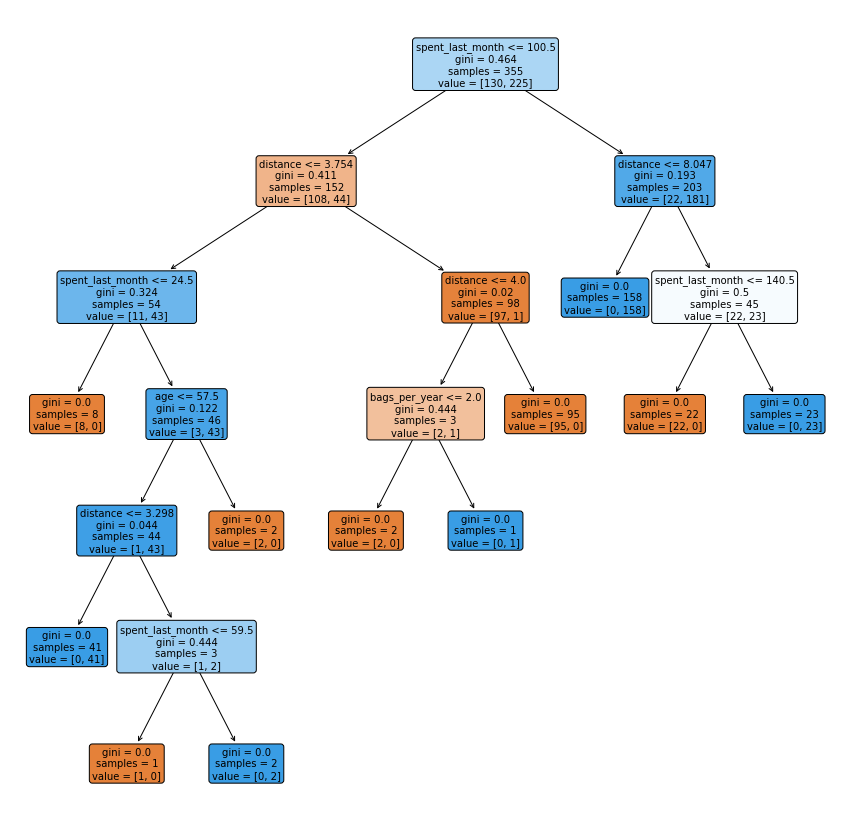

model classes:
No, Yes


In [30]:
# Now we want to visualize the tree
# We can do so with export_graphviz
# Alternatively for class_names use entr_model.classes_
tree_plot(entr_model, feature_names=feature_names)

## Model 1: Entropy model - no max_depth: Interpretation and evaluation

In [31]:
print_incorrect(y_pred, y_test)

incorrect classifications:
[index:  74]  |  predicted:  Yes  |  actual:    No
[index:  82]  |  predicted:   No  |  actual:   Yes


In [32]:
# Run this block for model evaluation metrics 
print("Model Entropy - no max depth")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test,y_pred, pos_label = "Yes"))
print('Precision score for "No"' , metrics.precision_score(y_test,y_pred, pos_label = "No"))
print('Recall score for "Yes"' , metrics.recall_score(y_test,y_pred, pos_label = "Yes"))
print('Recall score for "No"' , metrics.recall_score(y_test,y_pred, pos_label = "No"))

Model Entropy - no max depth
Accuracy: 0.9831932773109243
Balanced accuracy: 0.9813946216385241
Precision score for "Yes" 0.9871794871794872
Precision score for "No" 0.975609756097561
Recall score for "Yes" 0.9871794871794872
Recall score for "No" 0.975609756097561


In [33]:
print(len(X_test))

119


What can you infer from these results? Write your conclusions here:<br><br>
This model has a relatively high accuracy rating. It correctly classified around 98% of the test set. Its precision score is relatively high, indicating a low rate of false positives. That said, the test set is very small. This model made two incorrect classifications on the test set. It returned one incorrect `No` and one incorrect `Yes`. The differences in performance among the above metrics are due to the inherent class imbalance of this dataset.<br><br>
The plot of this decision tree reveals that `spent_last_month` and `distance` account for many of this model's intermediate classification nodes. None of these thresholds seems arbitrary or likely to exist as a result of fitting to noise. The age, bags per year, and distance thresholds are easy to understand. They represent plausible boundaries within a sample of a coffee customer population.

## Model 2: Gini impurity model - no max_depth

Gini impurity, like entropy, is a measure of how well a given feature (and threshold) splits the data into categories.

Their equations are similar, but Gini impurity doesn't require logorathmic functions, which can be computationally expensive. 

In [34]:
# Make a variable called gini_model, and assign it exactly what you assigned entr_model with above, but with the
# criterion changed to 'gini'
# Call fit() on the gini_model as you did with the entr_model
# Call predict() on the gini_model as you did with the entr_model
# Turn y_pred into a series, as before
gini_model = tree.DecisionTreeClassifier(criterion='gini', random_state=TREE_SEED)
y_pred = fit_train_predict(gini_model, X_train, y_train, X_test)

# Check out gini_model
gini_model

DecisionTreeClassifier(random_state=1234)

model: DecisionTreeClassifier(random_state=1234):
Branch Paths:
<<< True <<<   >>> False >>>


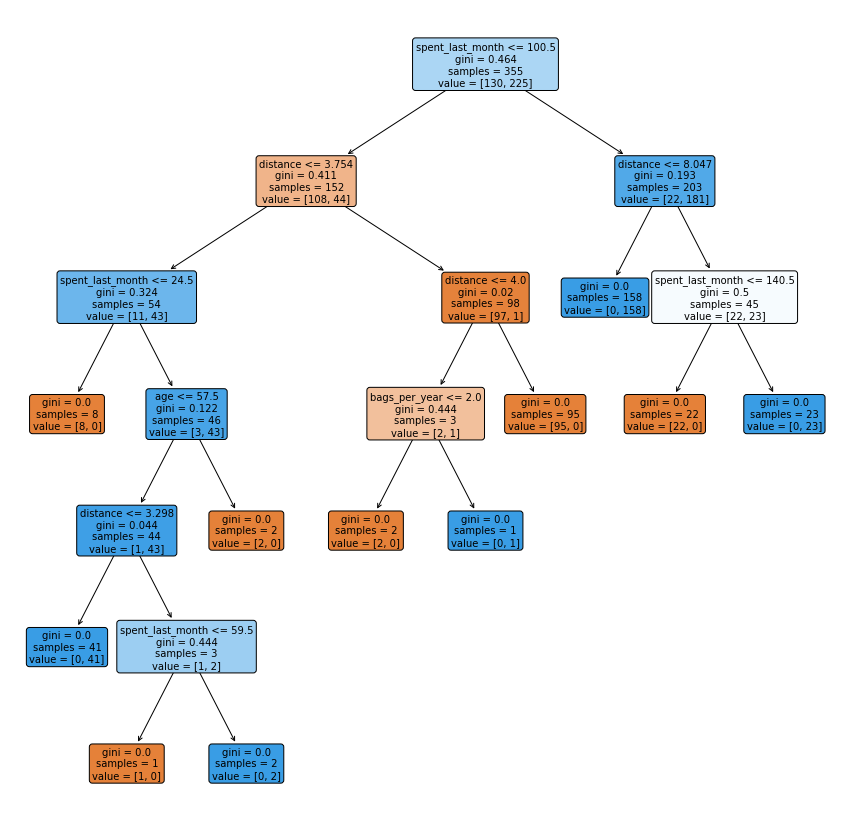

model classes:
No, Yes


In [35]:
# As before, but make the model name gini_model
# Alternatively for class_names use gini_model.classes_
tree_plot(gini_model, feature_names)

In [36]:
print_incorrect(y_pred, y_test)

incorrect classifications:
[index:  74]  |  predicted:  Yes  |  actual:    No
[index:  82]  |  predicted:   No  |  actual:   Yes


In [37]:
# Run this block for model evaluation
print("Model Gini impurity model")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred, pos_label = "Yes"))
print('Recall score' , metrics.recall_score(y_test,y_pred, pos_label = "No"))

Model Gini impurity model
Accuracy: 0.9831932773109243
Balanced accuracy: 0.9813946216385241
Precision score 0.9871794871794872
Recall score 0.975609756097561


How do the results here compare to the previous model? Write your judgements here: 

The results are identical to those of the previous model. The indices of incorrect classifications are identical. The `gini_model` would be preferable to `entr_model` in other use cases, as it is less computationally expensive.<br><br>For this use case, computational cost is irrelevant. The problem this model aims to address is not better served by less computationally expensive models. This business problem requires an accurate model to be selected, trained, and deployed to help make a single business decision. There is little incentive to minimize computational cost, as there is no intent to deploy this model such that it will be returning more than one prediction.

## Model 3: Entropy model - max depth 3
We're going to try to limit the depth of our decision tree, using entropy first.  

As you know, we need to strike a balance with tree depth. 

Insufficiently deep, and we're not giving the tree the opportunity to spot the right patterns in the training data.

Excessively deep, and we're probably going to make a tree that overfits to the training data, at the cost of very high error on the (hitherto unseen) test data. 

Sophisticated data scientists use methods like random search with cross-validation to systematically find a good depth for their tree. We'll start with picking 3, and see how that goes. 

In [38]:
#Â Made a model as before, but call it entr_model2, and make the max_depth parameter equal to 3. 
# Execute the fitting, predicting, and Series operations as before
entr_model_2 = tree.DecisionTreeClassifier(max_depth=3, random_state=TREE_SEED)
y_pred = fit_train_predict(entr_model_2, X_train, y_train, X_test)

model: DecisionTreeClassifier(max_depth=3, random_state=1234):
Branch Paths:
<<< True <<<   >>> False >>>


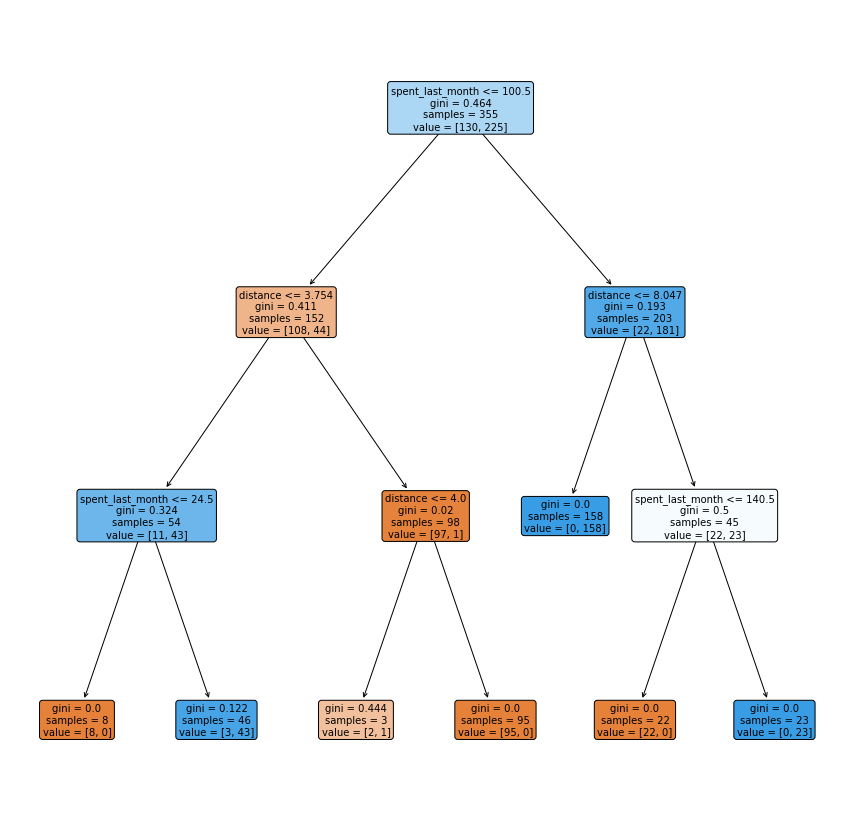

model classes:
No, Yes


In [39]:
# As before, we need to visualize the tree to grasp its nature
# Alternatively for class_names use entr_model2.classes_
tree_plot(entr_model_2, feature_names)


In [40]:
print_incorrect(y_pred, y_test)

incorrect classifications:
[index:  74]  |  predicted:  Yes  |  actual:    No
[index:  82]  |  predicted:   No  |  actual:   Yes
[index:  92]  |  predicted:  Yes  |  actual:    No


In [41]:
# Run this block for model evaluation 
print("Model Entropy model max depth 3")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test,y_pred, pos_label = "Yes"))
print('Recall score for "No"' , metrics.recall_score(y_test,y_pred, pos_label = "No"))

Model Entropy model max depth 3
Accuracy: 0.9747899159663865
Balanced accuracy: 0.9691994996873046
Precision score for "Yes" 0.9746835443037974
Recall score for "No" 0.9512195121951219


<b>So our accuracy decreased, but is this certainly an inferior tree to the max depth original tree we did with Model 1? Write your conclusions here:</b><br><br>

Whether this tree is inferior to the `entr_model` tree is dependent on the intended use of the model. For some use cases, I would argue this tree is a better choice. Given its simplicity, this tree is less likely to overfit, and its structure is more easily explained and understood than other models in this notebook. There are fewer instances of each relevant feature among the model's nodes. This model is "smoother" than others. If this smoothness results in fitting less to variance that exists as result of noise, this model is better. If this smoothness results in fitting less to variance that exists for other reasons, this model is worse.<br><br>

For this notebook's use case, this model is arguably inferior. For a model designed to inform a business decision by predicting future purchases, maximizing precision ("Precision score for 'Yes'") at a relatively high recall is of greater importance than computational cost or performance accross other metrics. This is especially important for this particular dataset, given the high density of observations near the apparent decision boundary of the scatterplot created during EDA.<br><br>

Assuming survey responses accurately predict the number of customers that will actually purchase a product, it is important to minimize the number of false positives at a relatively high recall. Ease of explanation would be second among priorities for this use case, but none of the models created so far have been prohibitively complex to explain. In earlier models, most of the node thresholds represent plausible ways to divide survey respondents by their intent to make a future purchase. It seems unlikely that previous models are fitting to noise more than signal. <br><br>

So far, there have only been minor differences in performance when changing from one model to the next. It may be that the test set is too small to offer a genuinely detailed comparison of different models. It is likely this problem would benefit from additional data collection more than it would benefit from improved modelling efforts.

## Model 4: Gini impurity  model - max depth 3
We're now going to try the same with the Gini impurity model. 

In [42]:
# As before, make a variable, but call it gini_model2, and ensure the max_depth parameter is set to 3
gini_model_2 = tree.DecisionTreeClassifier(
    criterion='gini', random_state=TREE_SEED, max_depth=3)

# Do the fit, predict, and series transformations as before. 
y_pred = fit_train_predict(gini_model_2, X_train, y_train, X_test)

model: DecisionTreeClassifier(max_depth=3, random_state=1234):
Branch Paths:
<<< True <<<   >>> False >>>


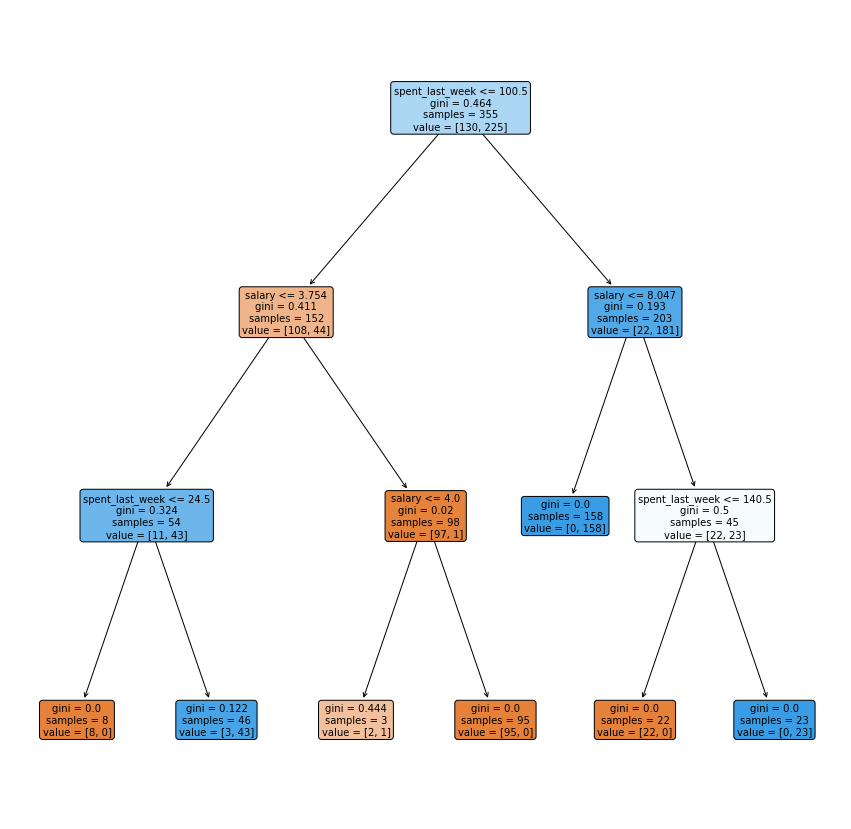

model classes:
No, Yes


In [43]:
tree_plot(gini_model_2, features)

In [44]:
print("Gini impurity  model - max depth 3")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred, pos_label = "Yes"))
print('Recall score' , metrics.recall_score(y_test,y_pred, pos_label = "No"))

Gini impurity  model - max depth 3
Accuracy: 0.9747899159663865
Balanced accuracy: 0.9691994996873046
Precision score 0.9746835443037974
Recall score 0.9512195121951219


<b>Now this is an elegant tree. Its accuracy might not be the highest, but it's still the best model we've produced so far. Why is that? Write your answer here:</b><br><br>
For other use cases, I agree; this model is the best produced. The paths this model takes from data point to prediction are simple, logical, easy to explain, and easy to understand. It offers relatively good performance, and it is less computationally expensive than other models. Features are represented symmetrically, and the thresholds of each node seem plausible. This is easily the most intuitive and easy to explain model created so far.  <br><br>

For this specific use case, I disagree. This is not the best model produced so far. There are plausible explanations for the thresholds and nodes set by other models, and the symmetry of features in a decision tree is not a reliable indicator of its predictive accuracy or its ability to generalize to out of sample data.

# 4. Evaluating and concluding
## 4a. How many customers will buy Hidden Farm coffee? 
Let's first ascertain how many loyal customers claimed, in the survey, that they will purchase the Hidden Farm coffee. 

In [45]:
# Call value_counts() on the 'Decision' column of the original coffeeData
coffee.decision.value_counts()

Yes    303
No     171
Name: decision, dtype: int64

Let's now determine the number of people that, according to the model, will be willing to buy the Hidden Farm coffee. 
1. First we subset the Prediction dataset into `new_X` considering all the variables except `Decision` 
2. Use that dataset to predict a new variable called `potential_buyers`

In [46]:
# Feature selection
# Make a variable called feature_cols, and assign it a list containing all the column names except 'Decision'
'''Such a list was already defined earlier in this notebook. It was assigned to 
the variable features.
'''
feature_cols = features

# Make a variable called new_X, and assign it the subset of Prediction, containing just the feature_cols 
new_x = prediction[feature_cols]

In [47]:
# Call get_dummies() on the Pandas object pd, with new_X plugged in, to one-hot encode all features in the training set
new_x = pd.get_dummies(new_x)

# Make a variable called potential_buyers, and assign it the result of calling predict() on a model of your choice; 
# don't forget to pass new_X to predict()
final_model = tree.DecisionTreeClassifier(random_state=TREE_SEED)
predict_out = fit_train_predict(final_model, X, y, new_x)

In [48]:
# Let's get the numbers of YES's and NO's in the potential buyers 
# Call unique() on np, and pass potential_buyers and return_counts=True 
print(f'Predicted purchases: {predict_out.value_counts().Yes}')
print(f'Survey-indicated purchases: {no_prediction.decision.value_counts().Yes}')

Predicted purchases: 177
Survey-indicated purchases: 303


The text for this markdown cell originally read:<br>
<i>The total number of potential buyers is 303 + 183 = 486.</i> <br><br>

For my chosen model, the number of predicted purchases is 177.

In [49]:
# Print the total number of surveyed people 
print(f'Total survey respondents: {len(coffee)}')
print(f'Respondents with complete answers: {len(no_prediction)}')
print(f'Percent with complete answers: {100*len(no_prediction)/len(coffee):.2f}%')

Total survey respondents: 702
Respondents with complete answers: 474
Percent with complete answers: 67.52%


In [50]:
# Let's calculate the proportion of buyers
self_reported_buyers = no_prediction.decision.value_counts()['Yes']
predicted_buyers = predict_out.value_counts()['Yes']
predicted_total = predicted_buyers + self_reported_buyers
predicted_percentage = predicted_total/len(coffee)
print('Potential purchasers of Hidden Farm coffee\n'+ 79*'=')
for name, number in (
        ('Survey-indicated (self-assessment): ', self_reported_buyers),
        ('Predicted: ', predicted_buyers),
        ('Predicted total: ', predicted_total),
        ('Proportion: ', f'{predicted_total}/{len(coffee)}')):
    print(f'{name}{number}')


Potential purchasers of Hidden Farm coffee
Survey-indicated (self-assessment): 303
Predicted: 177
Predicted total: 480
Proportion: 480/702


In [51]:
# Print the percentage of people who want to buy the Hidden Farm coffee, by our model 
print(f'Predicted percentage: {100*predicted_percentage:.2f}%')

Predicted percentage: 68.38%


## 4b. Decision

#### Prompt
Remember how you thought at the start: if more than 70% of the interviewed customers are likely to buy the Hidden Farm coffee, you will strike the deal with the local Hidden Farm farmers and sell the coffee. Otherwise, you won't strike the deal and the Hidden Farm coffee will remain in legends only. Well now's crunch time. Are you going to go ahead with that idea? If so, you won't be striking the deal with the Chinese farmers. 

They're called `decision trees`, aren't they? So where's the decision? What should you do? (Cue existential cat emoji). 

Ultimately, though, we can't write an algorithm to actually *make the business decision* for us. This is because such decisions depend on our values, what risks we are willing to take, the stakes of our decisions, and how important it us for us to *know* that we will succeed. What are you going to do with the models you've made? Are you going to risk everything, strike the deal with the *Hidden Farm* farmers, and sell the coffee? 

The philosopher of language Jason Stanley once wrote that the number of doubts our evidence has to rule out in order for us to know a given proposition depends on our stakes: the higher our stakes, the more doubts our evidence has to rule out, and therefore the harder it is for us to know things. We can end up paralyzed in predicaments; sometimes, we can act to better our situation only if we already know certain things, which we can only if our stakes were lower and we'd *already* bettered our situation. 

Data science and machine learning can't solve such problems. But what it can do is help us make great use of our data to help *inform* our decisions.

#### My response

Without additional information and domain knowledge, I would not purchase Hidden Farm coffee, as 68 is not greater than 70. Even if this predicted percentage was significantly higher than 70%, I would not purchase the coffee unless all of the conditions listed below were met.<br><br>
With a result of 68%, I would purchase the coffee <i>only</i> if the 70% threshold
* was set such that it accounts for response bias
    * Scenarios in which the difference in a customer's self-assessment and their actual intent to purchase at the time of the survey creates a dataset that isn't representative of its respondents' actual intent to purchase.
* was set such that it accounts for non-response bias
    * A significant portion of respondents, the `prediction` subset, did not provide an answer to the question about whether they would buy Hidden Farm Coffee. Non-response bias is relevant to scenarios in which the distribution of the `prediction` subset differs significantly from that of the `no_prediction` subset. If the `decision` of all or most of the individuals in the `prediction` subset was `No`, these modelling efforts offer little useful insight. Further, the predictive models created in this notebook are specific to the "most loyal customers" of RR Diner coffee. Non-response bias is relevant to any application of these models to customers who were not surveyed. I would not purchase the Hidden Farm coffee if the 70% threshold was set under the assumption that the distribution of intent to purchase among respondents is identical to that of customers who were not part of this survey.
* was set based on the performance of past surveys and modelling efforts
    * At least one similarly conducted and analyzed survey was used in the past to create a predictive model of customer purchases. Data was collected again to measure the true accuracy of predictions generated. The ratio of predicted to actual sales was factored into the equation that set the 70% threshold for this business problem.
* was <i>not</i> set such that it accounts for any indirect benefits of purchasing Hidden Farm coffee

The above conditions met, I would still not purchase the Hidden Farm coffee based on the results of modelling alone. I would require a comprehensive understanding of Hidden Farm as both a business entity and a coffee grower. I would need to be familiar with their product, its quality, and its consistency over several growing seasons. I would consult with several Q Graders to ensure that Hidden Farm's product meets or exceeds the quality and consistency standards established by RR Diner Coffee's other offerings. I would ensure that Hidden Farm coffee's product was compatbile with RR Diner Coffee's processing and roasting equipment and practices. I would consult with a financial advisor and verify that purchasing coffee from Hidden Farm represented an acceptable risk.

These and many other conditions met, I would purchase the coffee only if doing so would also generate useful publicity or provide other benefits to RR Diner Coffee which, combined in value, make up for the 2% difference between predicted sales and the appropriately set 70% purchase decision threshold.
 

## 5. Random Forest
You might have noticed an important fact about decision trees. Each time we run a given decision tree algorithm to make a prediction (such as whether customers will buy the Hidden Farm coffee) we will actually get a slightly different result. This might seem weird, but it has a simple explanation: machine learning algorithms are by definition ***stochastic***, in that their output is at least partly determined by randomness. 

To account for this variability and ensure that we get the most accurate prediction, we might want to actually make lots of decision trees, and get a value that captures the centre or average of the outputs of those trees. Luckily, there's a method for this, known as the ***Random Forest***. 

Essentially, Random Forest involves making lots of trees with similar properties, and then performing summary statistics on the outputs of those trees to reach that central value. Random forests are hugely powerful classifers, and they can improve predictive accuracy and control over-fitting. 

Why not try to inform your decision with random forest? You'll need to make use of the RandomForestClassifier function within the sklearn.ensemble module, found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

### 5a. Import necessary modules

Imports have been moved to the "Imports" cell of this notebook.

### 5b. Model
You'll use your X_train and y_train variables just as before.

You'll then need to make a variable (call it firstRFModel) to store your new Random Forest model. You'll assign this variable the result of calling RandomForestClassifier().

Then, just as before, you'll call fit() on that firstRFModel variable, and plug in X_train and y_train.

Finally, you should make a variable called y_pred, and assign it the result of calling the predict() method on your new firstRFModel, with the X_test data passed to it. 

In [52]:
# Plug in appropriate max_depth and random_state parameters 
rf_model = RandomForestClassifier(max_depth=3, random_state=TREE_SEED)
rf_model.fit(X_train, y_train)
y_pred = pd.Series(rf_model.predict(X_test))

In [53]:
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred, pos_label = "Yes"))
print('Recall score' , metrics.recall_score(y_test,y_pred, pos_label = "No"))

Accuracy: 0.9411764705882353
Balanced accuracy: 0.9204190118824265
Precision score 0.927710843373494
Recall score 0.8536585365853658


In [54]:
print_incorrect(y_pred, y_test)

incorrect classifications:
[index:  15]  |  predicted:   No  |  actual:   Yes
[index:  28]  |  predicted:  Yes  |  actual:    No
[index:  81]  |  predicted:  Yes  |  actual:    No
[index:  98]  |  predicted:  Yes  |  actual:    No
[index: 103]  |  predicted:  Yes  |  actual:    No
[index: 108]  |  predicted:  Yes  |  actual:    No
[index: 117]  |  predicted:  Yes  |  actual:    No


In [55]:
rf_model.fit(X, y)
rf_predict_out = pd.Series(rf_model.predict(new_x))
rf_predicted_buyers = rf_predict_out.value_counts()['Yes']
rf_predicted_total = self_reported_buyers + rf_predicted_buyers

In [56]:
for name, number in (
        ('Survey-indicated (self-assessment): ', self_reported_buyers),
        ('Predicted: ', rf_predicted_buyers),
        ('Predicted total: ', rf_predicted_total),
        ('Proportion: ', f'{rf_predicted_total}/{len(coffee)}'),
        ('Percentage: ', f'{100*rf_predicted_total/len(coffee):.2f}')):
    print(f'{name}{number}')

Survey-indicated (self-assessment): 303
Predicted: 185
Predicted total: 488
Proportion: 488/702
Percentage: 69.52


### 5c. Revise conclusion

Has your conclusion changed? Or is the result of executing random forest the same as your best model reached by a single decision tree? 

The results are different; my conclusion is not.